# QUANTUM FOURIER TRANSFORM

In this tutorial, we provide a detailed implementation of the Quantum Fourier Transform (QFT) and the inverse thereof, using Amazon Braket's SDK.
We provide two different implementations, with and without recursion.
The QFT is an important subroutine to many quantum algorithms, most famously Shor's algorithm for factoring and the quantum phase estimation (QPE) algorithm for estimating the eigenvalues of a unitary operator [1, 2]. 
The QFT can be performed efficiently on a quantum computer, using only ${\displaystyle O(n^{2})}$ single-qubit Hadamard gates and two-qubit controlled phase shift gates, where ${\displaystyle n}$ is the number of qubits. 
We first review the basics of the quantum Fourier transform, and its relation to the discrete (classical) Fourier transform. 
We then implement the QFT in code two ways: recursively and non-recursively. 
This notebook also showcases Braket's `circuit.subroutine` functionality, which allows one to define custom methods and add them to the Circuit class.

## TECHNICAL BACKGROUND OF QFT 

__Introduction__: The Quantum Fourier Transform (QFT) is a quantum algorithm for applying the discrete Fourier transform to the amplitudes of a quantum state.  The QFT is therefore a quantum analog of the classical discrete Fourier transform [1, 2].

Let us first review the classical discrete Fourier transform (DFT). 
Given a vector $(x_0,\ldots,x_{N-1})\in\mathbb{C}^N$, the discrete Fourier transform computes the vector $(y_0,\ldots,y_{N-1})$ for which
$$ y_j = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} x_k e^{\frac{2\pi i}{N}jk}.$$

__Quantum Fourier Transformation__: In close analogy to the classical Fourier transform, the QFT takes an arbitrary input state $\left|\mathrm{input}\right> = \sum x_{j}\left|j\right>$ (with the orthonormal basis states $\left|0\right>$, $\left|1\right>$, ..., $\left|N-1\right>$), and maps it to the output state
$$\left|\mathrm{output}\right> = \sum_{k} y_{k}\left|k\right>,$$ 
with coefficients
$$y_{k}=\frac{1}{\sqrt{N}}\sum_{n}x_{n}e^{2\pi i\cdot n\cdot k/N}.$$

__Binary representation (notation)__: We take $N=2^{n}$, with $n$ being the number of qubits. In the binary representation, the states $\{\left|x\right>\}$ read explicitly 

$$\left|x\right> = \left|x_{1}x_{2}\dots x_{n}\right>,$$ 
where
$$x = x_{1}2^{n-1}+x_{2}2^{n-2}+\dots+x_{n}2^{0}.$$

For example, in a four-qubit system $\left|7\right> = \left|0111\right>$ and $\left|8\right> = \left|1000\right>$.
Similarly, we use the following notation to represent binary fractions:

$$[0.x_{l}x_{l+1}\dots x_{m}] = \frac{x_{l}}{2^{1}} + \frac{x_{l+1}}{2^{2}} + \frac{x_{m}}{2^{m-l+1}}.$$

__Product representation of QFT__: Very often, the product representation of the QFT proves useful. Accordingly, the QFT can be expressed (up to normalization) as
$$\left|x_{1}x_{2}\dots x_{n}\right> \longrightarrow \frac{(\left|0\right>+e^{2\pi i[0.x_{n}]}\left|1\right>)\otimes (\left|0\right>+e^{2\pi i[0.x_{n-1}x_{n}]}\left|1\right>)\otimes \dots \otimes (\left|0\right>+e^{2\pi i[0.x_{1}x_{2}\dots x_{n}]}\left|1\right>)}{2^{n/2}}.$$
For example, the QFT on three qubits can be written as 

$$\mathrm{QFT}\left|x_{1}x_{2}x_{3}\right> = \frac{1}{2^{3/2}}\left(\left|0\right>+e^{2\pi i[0.x_{3}]}\left|1\right>\right) \otimes \left(\left|0\right>+e^{2\pi i[0.x_{2}x_{3}]}\left|1\right>\right) \otimes \left(\left|0\right>+e^{2\pi i[0.x_{1}x_{2}x_{3}]}\left|1\right>\right).$$

Thus, for the simple input state $\left|0,0,0\right>$ with $x_{i}=0$, it is easy to see that the QFT produces a uniform superposition of all computational basis vectors (since only the Hadamard gates act non-trivially in this case).  Explicitly:
$$
\begin{split}
\mathrm{QFT}\left|0,0,0\right> & = \frac{1}{\sqrt{2^{3}}}(\left|0\right>+\left|1\right>) \otimes (\left|0\right>+\left|1\right>) \otimes (\left|0\right>+\left|1\right>) \\
 & = \bigotimes_{i} \left|+\right>_{i}
\end{split}
$$

__Inverse QFT__: Below we will also implement the inverse QFT algorithm (denoted by $\mathrm{QFT}^{\dagger}$, or sometimes $\mathrm{QFT}^{-1}$), which fulfills $\mathrm{QFT}\cdot\mathrm{QFT}^{\dagger}=\mathbb{1}$, where $\mathbb{1}$ is the identity. For example, with the inverse QFT we can invert the above three qubit QFT as 

$$\mathrm{QFT}^\dagger\mathrm{QFT}\left|x_{1}x_{2}x_{3}\right> = \mathrm{QFT}^{\dagger}(\left|0\right>+e^{2\pi i[0.x_{3}]}\left|1\right>) \otimes (\left|0\right>+e^{2\pi i[0.x_{2}x_{3}]}\left|1\right>) \otimes (\left|0\right>+e^{2\pi i[0.x_{1}x_{2}x_{3}]}\left|1\right>)/2^{3/2}=\left|x_{1}x_{2}x_{3}\right>.$$

__Example for inverse QFT:__ For further illustration, we will run a concrete example of this kind below. 
Specifically, consider the following example with $x_{1}=0$, $x_{2}=1$, and $x_{3}=0$ encoding the number 2 in binary representation. 
Accordingly, we prepare the initial state (up to normalization)

$$\left|\Psi_\mathrm{in}\right>=(\left|0\right>+e^{2\pi i[0.0]}\left|1\right>) \otimes (\left|0\right>+e^{2\pi i[0.10]}\left|1\right>) \otimes (\left|0\right>+e^{2\pi i[0.010]}\left|1\right>),$$
which is equivalent to 
$$\left|\Psi_\mathrm{in}\right>=(\left|0\right>+\left|1\right>) \otimes (\left|0\right>+e^{2\pi i\frac{1}{2}}\left|1\right>) \otimes (\left|0\right>+e^{2\pi i\frac{1}{4}}\left|1\right>).$$

This state can be prepared using the single-qubits gates $H$ and $R_{z}$ as follows: 

$$\left|\Psi_\mathrm{in}\right>=H\left|0\right> \otimes R_{z}(\pi)H\left|0\right> \otimes R_{z}(\pi/2)H\left|0\right>.$$

Based on the analysis above we then expect $\mathrm{QFT}^{\dagger} \left|\Psi_\mathrm{in}\right> = \left|0,1,0\right>$.
We can generalize the above example to multiple qubits with the following state preparation code:
```python
circ = Circuit()
circ.h(range(num_qubits))
for ii in range(num_qubits - 1):
    circ.rz(ii+1, math.pi/(2**ii))
```

## CIRCUIT IMPLEMENTATION OF QFT

The QFT circuit can be implemented using only Hadamard gates, controlled phase gates, and SWAP gates. The Hadamard gate $H$, the phase gate ${\displaystyle R_{m}}$, and the SWAP gate are given by
$$H = \frac{1}{\sqrt{2}}
\begin{pmatrix} 
1 & 1\\
1 & -1\\
\end{pmatrix} \qquad \qquad
R_{m} = 
\begin{pmatrix} 
1 & 0\\
0 & e^{\frac{2\pi i}{2^{m}}}\\
\end{pmatrix} \qquad \qquad
\mathrm{SWAP} = 
\begin{pmatrix} 
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}.$$

The details of the calculation can be found in a number of resources (including a great exposition on [Wikipedia](https://en.wikipedia.org/wiki/Quantum_Fourier_transform) [1]), but the circuit that implements this transformation reads as follows (note that we need to apply a series of swap gates to reverse the order of the qubits thereby recovering the QFT as described above): 
<div align="center"><img src="circuit.png"/></div>
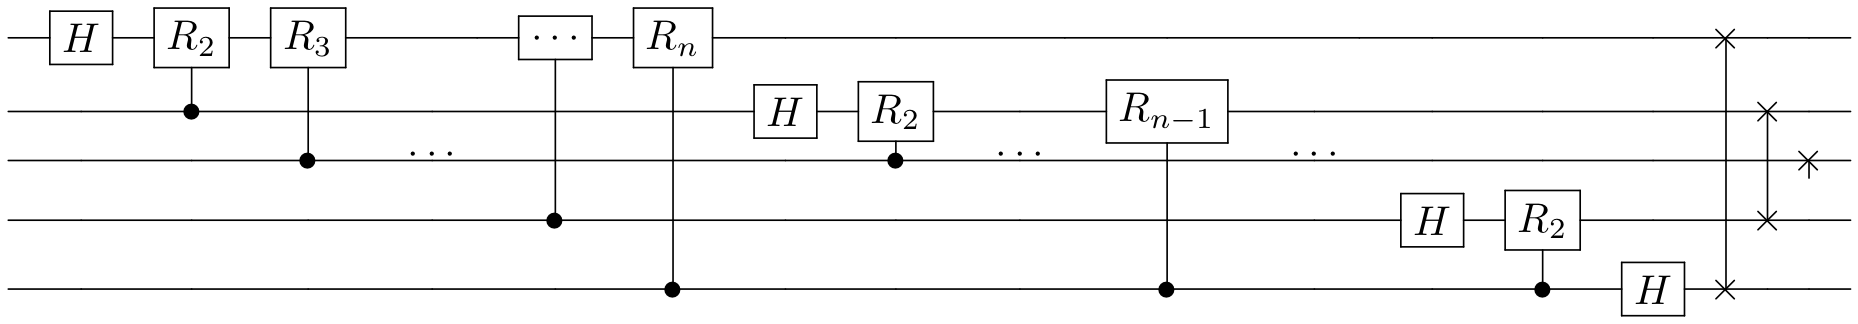

__Recursive Implemenation__: By inspection, we can define the first part of this circuit (i.e., everything except the SWAP gates) recursively as shown below: 
<div align="center"><img src="recursive_circuit.png"/></div>

where $\text{QFT}_k$ in the above is the part of the circuit excluding the final SWAP gates. 
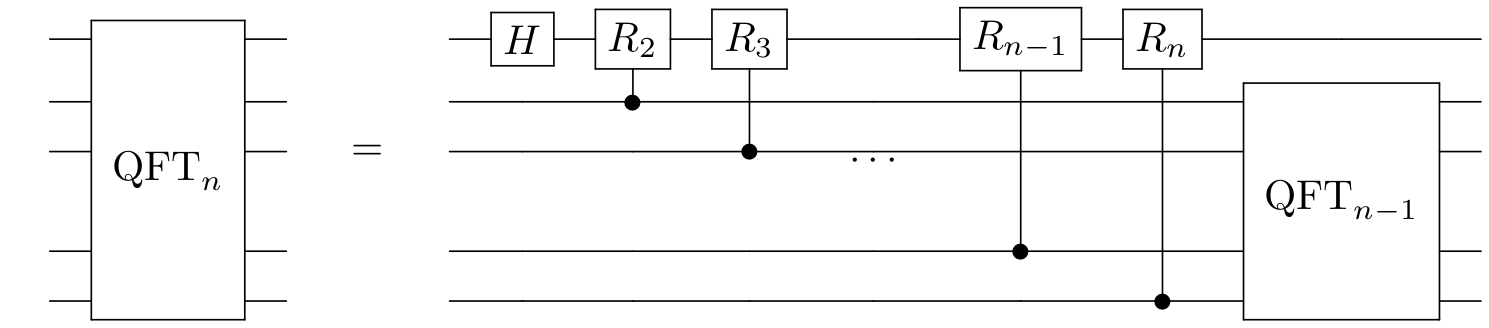

## IMPORTS and SETUP

In [1]:
# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator

In [3]:
# set up device: Local Simulator
device = LocalSimulator()

## IMPLEMENTATION OF THE QFT AND INVERSE QFT CIRCUITS

In this section we provide simple helper functions to implement the circuits for both QFT and inverse QFT. 
Specifically, we demonstrate how such modular building blocks can be registered as subroutines, using ```@circuit.subroutine(register=True)```.  

##### Recursive definition of the QFT

In [4]:
# qft subroutine without swaps
def qft_no_swap(qubits):    
    """
    Subroutine of the QFT excluding the final SWAP gates, applied to the qubits argument.
    Returns the a circuit object.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """

    # On a single qubit, the QFT is just a Hadamard.
    if len(qubits) == 1:
        return Circuit().h(qubits)
    
    # For more than one qubit, we define the QFT recursively (as shown on the right half of the image above):
    else:
        qftcirc = Circuit()
        
        # First add a Hadamard gate
        qftcirc.h(qubits[0])
        
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        for k, qubit in enumerate(qubits[1:]):
            qftcirc.cphaseshift(qubit, qubits[0], 2*math.pi/(2**(k+2)))
            
        # Now apply the above gates recursively to the rest of the qubits
        qftcirc.add(qft_no_swap(qubits[1:]))
        
    return qftcirc


# To complete the full QFT, add swap gates to reverse the order of the qubits
@circuit.subroutine(register=True)
def qft_recursive(qubits):
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # First add the QFT subroutine above
    qftcirc.add(qft_no_swap(qubits))
    
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(len(qubits)/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
    
    return qftcirc

##### Non-recursive definition of the QFT

In [5]:
@circuit.subroutine(register=True)
def qft(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc

##### Inverse QFT

In [6]:
@circuit.subroutine(register=True)
def inverse_qft(qubits):
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (int): The list of qubits on which to apply the inverse QFT
    """
    # instantiate circuit object
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    # First add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    # Start on the last qubit and work to the first.
    for k in reversed(range(num_qubits)):
    
        # Apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # These angles are the negative of the angle used in the QFT.
        # Start on the last qubit and iterate until the qubit after k.  
        # When num_qubits==1, this loop does not run.
        for j in reversed(range(1, num_qubits - k)):
            angle = -2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j],qubits[k], angle)
            
        # Then add a Hadamard gate
        qftcirc.h(qubits[k])
    
    return qftcirc

## VISUALIZATION OF THE QFT CIRCUIT

In order to check our implementation of the (inverse) QFT circuit, let us visualize them for small numbers of qubits. 
By inspection, we can see that the $\mathrm{QFT}$ and $\mathrm{QFT}^{\dagger}$ circuits will effectively cancel each other, as desired. 

**2 qubits:**

In [7]:
# show inverse QFT example circuit
num_qubits = 2
qubits=range(num_qubits)
my_qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(my_qft_circ)

# show inverse QFT example circuit
print('')
print('INVERSE-QFT CIRCUIT:')
my_iqft_circ = inverse_qft(qubits)
print(my_iqft_circ)

QFT CIRCUIT:
T  : |0|     1     |2| 3  |
                           
q0 : -H-PHASE(1.57)---SWAP-
        |             |    
q1 : ---C-----------H-SWAP-

T  : |0|     1     |2| 3  |

INVERSE-QFT CIRCUIT:
T  : | 0  |1|     2      |3|
                            
q0 : -SWAP---PHASE(-1.57)-H-
      |      |              
q1 : -SWAP-H-C--------------

T  : | 0  |1|     2      |3|


**3 qubits:**

In [8]:
# show inverse QFT example circuit
num_qubits = 3
qubits=range(num_qubits)
my_qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(my_qft_circ)

# show inverse QFT example circuit
print('')
print('INVERSE-QFT CIRCUIT:')
my_iqft_circ = inverse_qft(qubits)
print(my_iqft_circ)

QFT CIRCUIT:
T  : |0|     1     |      2       |     3     |4| 5  |
                                                      
q0 : -H-PHASE(1.57)-PHASE(0.785)-----------------SWAP-
        |           |                            |    
q1 : ---C-----------|------------H-PHASE(1.57)---|----
                    |              |             |    
q2 : ---------------C--------------C-----------H-SWAP-

T  : |0|     1     |      2       |     3     |4| 5  |

INVERSE-QFT CIRCUIT:
T  : | 0  |1|     2      |       3       |     4      |5|
                                                         
q0 : -SWAP------------------PHASE(-0.785)-PHASE(-1.57)-H-
      |                     |             |              
q1 : -|------PHASE(-1.57)-H-|-------------C--------------
      |      |              |                            
q2 : -SWAP-H-C--------------C----------------------------

T  : | 0  |1|     2      |       3       |     4      |5|


## NUMERICAL TEST EXPERIMENTS

In the following we will verify that our QFT implementation works as expected with a few test examples:
1. First, we will apply the QFT algorithm to the input state $\left|0,0,0\right>$. Here, we expect a uniform superposition of all basis vectors as output, as discussed above.  
2. Second, following our theoretical discussion above, we will apply the inverse QFT to a particular input state for which we expect a simple computational basis state as output. 
3. Finally, we verify that the $\mathrm{QFT}$ and $\mathrm{QFT}^{\dagger}$ circuits cancel each other, effectively yielding the identity gate. 

For the second example, we will prepare a specific input state using the following circuit:
```python
circ = Circuit()
circ.h(range(num_qubits))
for ii in range(num_qubits - 1):
    circ.rz(ii+1, math.pi/(2**ii))
```

This circuit prepares the binary representation of $|2\rangle$, for whatever number of qubits is set.
Disclaimer: Note that if you choose to run this on a real QPU, then you are likely to see imperfect measurement results due to experimental imperfection such as noise.

### NUMERICAL TEST EXAMPLE 1

First, let us apply the QFT algorithm to the input state $\left|0,0,0\right>$. Here, we expect a uniform superposition of all basis vectors as output, as discussed above.

Exact statevector:
 [(0.354+0j), (0.354+0j), (0.354+0j), (0.354+0j), (0.354+0j), (0.354+0j), (0.354+0j), (0.354+0j)]


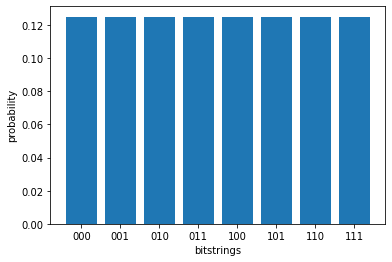

In [9]:
# check output for input |0,0,0> -> expect uniform distribution
num_qubits = 3
qubits=range(num_qubits)
my_qft_circ = qft(qubits)

# specify desired results_types
my_qft_circ.state_vector()
my_qft_circ.probability()

# Run the QFT on 3 qubits with all zeros input
task = device.run(my_qft_circ, shots=0)
result = task.result()
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');

Indeed, we do recover a uniform superposition of all basis vectors as output, as expected from our analysis above.

### NUMERICAL TEST EXAMPLE 2

Following our theoretical discussion above, we will apply the inverse QFT to a particular input state for which we expect a simple computational basis state as output.

In [10]:
# prepare initial state 
num_qubits = 3
qubits=range(num_qubits)
circ = Circuit()
circ.h(qubits)
for ii in range(num_qubits - 1):
    circ.rz(ii+1, math.pi/(2**ii))

print('1. Printing circuit for state preparation:')
print(circ)

# add QFT circuit
circ.inverse_qft(qubits)

# print circuit including QFT
print('')
print('2. Full circuit including inverse QFT:')
print(circ)

1. Printing circuit for state preparation:
T  : |0|   1    |
                 
q0 : -H----------
                 
q1 : -H-Rz(3.14)-
                 
q2 : -H-Rz(1.57)-

T  : |0|   1    |

2. Full circuit including inverse QFT:
T  : |0|   1    | 2  |3|     4      |       5       |     6      |7|
                                                                    
q0 : -H----------SWAP------------------PHASE(-0.785)-PHASE(-1.57)-H-
                 |                     |             |              
q1 : -H-Rz(3.14)-|------PHASE(-1.57)-H-|-------------C--------------
                 |      |              |                            
q2 : -H-Rz(1.57)-SWAP-H-C--------------C----------------------------

T  : |0|   1    | 2  |3|     4      |       5       |     6      |7|


Exact statevector:
 [0, 0, (-0.707-0.707j), 0, 0, 0, 0, 0]


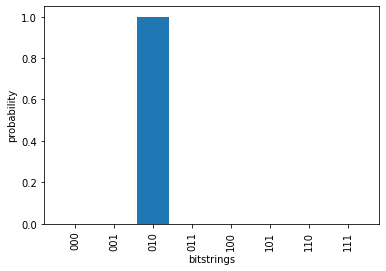

In [11]:
# specify desired results_types
circ.state_vector()
circ.probability()

# Run the QFT on 3 circuits with all zeros input
task = device.run(circ, shots=0)
result = task.result()
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=90);

As expected, all measurements show a unique bitstring corresponding to the integer number set with our initial state preparation, as expected.
Next, let us verify that this works independent of the number of qubits. 

1. Printing circuit for state preparation:
T  : |0|    1    |
                  
q0 : -H-----------
                  
q1 : -H-Rz(3.14)--
                  
q2 : -H-Rz(1.57)--
                  
q3 : -H-Rz(0.785)-

T  : |0|    1    |

2. Full circuit including inverse QFT:
T  : |0|    1    |    2    |3|     4      |       5       |            6             |       7       |     8      |9|
                                                                                                                     
q0 : -H-----------SWAP--------------------------------------------------PHASE(-0.393)---PHASE(-0.785)-PHASE(-1.57)-H-
                  |                                                     |               |             |              
q1 : -H-Rz(3.14)--|----SWAP------------------PHASE(-0.785)-PHASE(-1.57)-|-------------H-|-------------C--------------
                  |    |                     |             |            |               |                            
q2 : -H-Rz(1.57)--

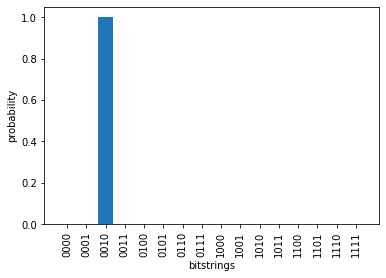

In [12]:
# prepare initial state 
num_qubits = 4
qubits=range(num_qubits)
circ = Circuit()
circ.h(qubits)
for ii in range(num_qubits - 1):
    circ.rz(ii+1, math.pi/(2**ii))

print('1. Printing circuit for state preparation:')
print(circ)

# add QFT circuit   
circ.inverse_qft(qubits)

# print circuit including QFT
print('')
print('2. Full circuit including inverse QFT:')
print(circ)

# specify desired results_types
circ.state_vector()
circ.probability()

# Run the QFT on 3 circuits with all zeros input
task = device.run(circ, shots=0)
result = task.result()
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=90);

### NUMERICAL TEST EXAMPLE 3

In this section, we verify that the $\mathrm{QFT}$ and $\mathrm{QFT}^{\dagger}$ circuits cancel each other, effectively yielding the identity gate $\mathbb{1}$.

Exact statevector:
 [(1+0j), 0, 0, 0, 0, 0, 0, 0]


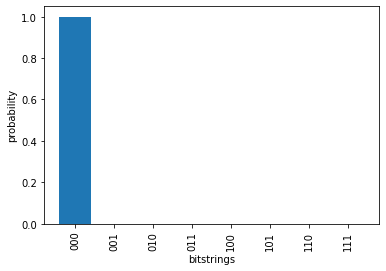

In [13]:
# prepare initial state 
num_qubits = 3
qubits=range(num_qubits)
circ = Circuit()

# add QFT circuit
circ.qft(qubits)
circ.inverse_qft(qubits)

# specify desired results_types
circ.state_vector()
circ.probability()

# Run the QFT on 3 circuits with all zeros input
task = device.run(circ, shots=0)
result = task.result()
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=90);

Exact statevector:
 [0, 0, 0, 0, 0, (1+0j), 0, 0]


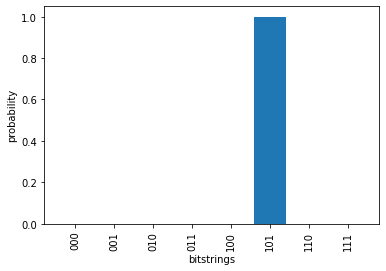

In [14]:
# prepare initial state 
num_qubits = 3
qubits=range(num_qubits)
circ = Circuit()
circ.x(0)
circ.x(2)

# add QFT circuit
  
circ.qft(qubits)
circ.inverse_qft(qubits)

# specify desired results_types
circ.state_vector()
circ.probability()

# Run the QFT on 3 circuits with all zeros input
task = device.run(circ, shots=0)
result = task.result()
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=90);

## COMPARISON OF IMPLEMENTATIONS

In this section we compare the two implementations (recursive vs. non-recursive), showing that they produce the same circuits. 
By inspection you can also check that the $\mathrm{QFT}$ and $\mathrm{QFT}^{\dagger}$ circuits cancel each other, effectively yielding the identity gate $\mathbb{1}$. 

In [15]:
# set qubits to perform (inverse) QFT on
qubits = [1,3,6,7]

# print circuits 
print('Circuit for QFT (using non-recursive implementation):')
print(qft(qubits))
print('')
print('Circuit for QFT (using recursive implementation):')
print(qft_recursive(qubits))
print('')
print('Circuit for inverse QFT:')
print(inverse_qft(qubits))

Circuit for QFT (using non-recursive implementation):
T  : |0|     1     |      2       |           3            |      4       |     5     | 6  | 7  |
                                                                                                 
q1 : -H-PHASE(1.57)-PHASE(0.785)---PHASE(0.393)---------------------------------------------SWAP-
        |           |              |                                                        |    
q3 : ---C-----------|------------H-|------------PHASE(1.57)-PHASE(0.785)---------------SWAP-|----
                    |              |            |           |                          |    |    
q6 : ---------------C--------------|------------C-----------|------------H-PHASE(1.57)-SWAP-|----
                                   |                        |              |                |    
q7 : ------------------------------C------------------------C--------------C-----------H----SWAP-

T  : |0|     1     |      2       |           3            |   

--- 
## APPENDIX

In [16]:
# Check SDK version
!pip show amazon-braket-sdk | grep Version

Version: 0.6.0


---
## REFERENCES

[1] Wikipedia: https://en.wikipedia.org/wiki/Quantum_Fourier_transform

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.